In [1]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Load Embeddings and Term Frequecies

In [22]:
mxm_dataset = pd.read_feather('../../data/transform/mxm_dataset.feather')
mxm_embeddings = pd.read_feather('../../data/transform/mxm_embeddings.feather')
mxm_tracks = pd.read_feather('../../data/transform/unique_tracks.feather')

In [36]:
tf_data = mxm_dataset.sample(frac= 1, random_state = 0).reset_index()
em_data = mxm_embeddings.sample(frac= 1, random_state = 0).reset_index()

# Methods for Interacting with Topics

In [24]:
def corpus_topics_top_words(model, features, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict[topic_idx] = [features[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topic_dict

In [25]:
def song_topics(model, song):
    topic_dict = []
    for topic_idx, topic in enumerate(model.components_):
        topic_dict.append(sum(topic*song))
    return topic_dict

# Remove Stopwords From Dataset

In [39]:
features = tf_data.columns
stop_words_tidytext = pd.read_feather('../../data/transform/stop_words_tidytext')
stop_words = []
for i in stop_words_tidytext.word:
    if i in features:
        stop_words.append(i)

tf_data = tf_data.drop(stop_words, axis=1)
tf_data = tf_data.drop(['track_id','index'], axis=1)

# Train Topic Modeling Algorith

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
#best performing model from previous analysis

lda_tf_25 = LatentDirichletAllocation(n_topics=25, random_state=0)
lda_tf_25.fit(tf_data)

/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=25,
             perp_tol=0.1, random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

# Topic Modeling Results

In [44]:
top_per_topic_words = corpus_topics_top_words(lda_tf_25, tf_data.columns.values, 10)

for i in list(top_per_topic_words.keys()):
    print(str(i) + ' '+ str(top_per_topic_words[i]))

0 ['love', 'heart', 'alway', 'hold', 'feel', 'onli', 'kiss', 'true', 'pleas', 'mine']
1 ['na', 'da', 'di', 'che', 'la', 'il', 'se', 'mi', 'eu', 'ma']
2 ['babi', 'ooh', 'woman', 'jag', 'det', 'babe', 'du', 'alright', 'crazi', 'och']
3 ['world', 'god', 'heaven', 'war', 'angel', 'live', 'earth', 'king', 'fight', 'born']
4 ['walk', 'blue', 'black', 'town', 'rememb', 'white', 'red', 'watch', 'morn', 'shine']
5 ['run', 'call', 'friend', 'nobodi', 'beauti', 'lover', 'care', 'fool', 'river', 'push']
6 ['die', 'burn', 'fire', 'ah', 'dead', 'hell', 'flame', 'citi', 'kill', 'devil']
7 ['night', 'light', 'dream', 'sky', 'star', 'fli', 'wind', 'dark', 'alon', 'sleep']
8 ['time', 'feel', 'life', 'ca', 'live', 'tri', 'mind', 'believ', 'day', 'chang']
9 ['everyth', 'talk', 'anyth', 'easi', 'somebodi', 'honey', 'sorri', 'cos', 'drive', 'dem']
10 ['yeah', 'everybodi', 'uh', 'mama', 'yea', 'bout', 'feelin', 'parti', 'brother', 'babi']
11 ['ya', 'de', 'ik', 'en', 'van', 'je', 'bien', 'pa', 'dat', 'het']
1

In [33]:
#save per/song topic results to df
song_topic_weights = np.zeros([len(tf_data),25])
for i in tqdm(range(len(tf_data))):
    song_weights = pd.Series(song_topics(lda_tf_25, tf_data.iloc[i]))
    song_topic_weights[i] = song_weights

100%|██████████| 237662/237662 [43:24<00:00, 91.24it/s]


In [118]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(song_topic_weights)

In [119]:
initial_topic_names = list(range(25))
song_topic_weights_df = pd.DataFrame(data =scaled, columns=initial_topic_names)
song_topic_weights_df['track_id'] = mxm_dataset.track_id 

In [120]:
df_topic_weights_reduced_df = song_topic_weights_df[['track_id', 0,3,6,17]]
df_topic_weights_reduced_df.columns = 'track_id', 'love','religion','death','dancing'

In [285]:
def plot_song(song_data, features):
    colors = [ 'red', 'green', 'navy','yellow']
    max_cat = np.argmax(np.array(song_data))
    explode = [0,0,0,0]
    explode[max_cat] = 0.02
    fig1, ax1 = plt.subplots()
    ax1.pie(100000*song_data, startangle=90, labels=features,colors=colors,explode=explode)
    ax1.axis('equal')

    plt.show()

Artist: Leonardo'S Bride
Song: Stay


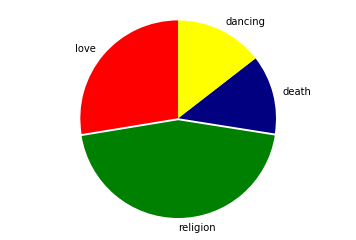

In [292]:
song_index = 1002
song_data = df_topic_weights_reduced_df.drop(['track_id'],axis=1).loc[song_index]
features = list(df_topic_weights_reduced_df.drop(['track_id'],axis=1).columns)
song_info(df_topic_weights_reduced_df['track_id'].loc[song_index])

plot_song(song_data, features)

In [293]:
#find most similar word embedding with knn
from sklearn.neighbors import KNeighborsClassifier

test_track_id = em_data.track_id.iloc[song_index]
test_track_vector = em_data.drop(['track_id','index'],axis=1).iloc[song_index]
knn = KNeighborsClassifier(n_neighbors=1)
train_data = em_data[em_data.track_id != test_track_id]
train_X = train_data.drop(['track_id','index'],axis=1)
train_y = train_data['track_id']
    
knn.fit(train_X, train_y)
closest_song = knn.predict(test_track_vector.values.reshape(1,-1))
    

Artist: As Cities Burn
Song: Thus From My Lips_ By Yours_ My Sin Is Purged


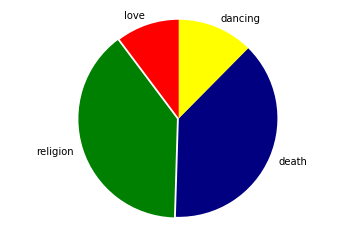

In [294]:
song_data = df_topic_weights_reduced_df[df_topic_weights_reduced_df.track_id==closest_song[0]].reset_index()
song_data = song_data.drop(['track_id','index'],axis=1)
features = list(df_topic_weights_reduced_df.drop(['track_id'],axis=1).columns.values)
song_info(closest_song[0])
plot_song(song_data.loc[0], features)

In [284]:
def song_info(track_id, df=mxm_tracks):
    artist = df[df['track_id']==track_id].artist_name.values[0]
    song = df[df['track_id']==track_id].title.values[0]
    print('Artist: ' +artist)
    print('Song: '+song)